In [87]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.metrics import f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
def clean_dataset(df):
    
    variables_to_remove = ['OP_CARRIER_FL_NUM', 'DEP_TIME','ARR_TIME','TAXI_OUT', 'WHEELS_OFF','WHEELS_ON','TAXI_IN', 
                           'CANCELLED', 'CANCELLATION_CODE','DIVERTED','AIR_TIME','CARRIER_DELAY','WEATHER_DELAY',
                           'NAS_DELAY', 'SECURITY_DELAY','LATE_AIRCRAFT_DELAY','CRS_ELAPSED_TIME','ACTUAL_ELAPSED_TIME',
                           'Unnamed: 27','Unnamed: 0']

    df.drop(variables_to_remove, axis = 1, inplace = True)

    df=df.rename(columns={'FL_DATE':'DATE','OP_CARRIER':'AIRLINE','DEST':'DESTIN',
                    'CRS_DEP_TIME':'SCHED_DEPARTURE','DEP_DELAY':'DEPARTURE_DELAY',
                    'CRS_ARR_TIME':'SCHED_ARRIVAL','ARR_DELAY':'ARRIVAL_DELAY'})

    df.dropna(inplace = True)
    
    df['DATE'] = pd.to_datetime(df['DATE'], format = '%Y-%m-%d', errors = 'coerce')
    
    return df


def format_hour(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

def combine_date(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
    
def transform_hour(df):
    df['SCHED_DEPARTURE'] = df['SCHED_DEPARTURE'].apply(format_hour)
    df['SCHED_ARRIVAL'] = df['SCHED_ARRIVAL'].apply(format_hour)
    
    return df

def create_flight_time(df):    
    lista=[]
    for i,v in df[['DATE','SCHED_DEPARTURE']].iterrows() :   #iteration over rows
    
        try :
            lista.append(datetime.datetime.combine(df['DATE'][i],df['SCHED_DEPARTURE'][i]))
        except:
            lista.append('error')        #if something goes wrong lista appens 'error'

    indices = [i for i, x in enumerate(lista) if x == "error"]   #test of lista to see if it'ok
    print ('Errors during data transformation :  ', len(indices))

    df['DATE_TIME']=lista
    return df


def airline_name(df):
    
    df["AIRLINE_NAME"]=df.apply(lambda x: airlines.loc
                           [airlines['CODE'] == x["AIRLINE"],"AIRLINE"].values[0],axis=1)
    return df

def geo (df):
    df=pd.merge(df,airports[['IATA_CODE','LATITUDE','LONGITUDE']],left_on='ORIGIN', right_on='IATA_CODE')
    df=df.rename(columns={'LATITUDE':'OR_LATITUDE','LONGITUDE':'OR_LONGITUDE'})
   
    df=pd.merge(df,airports[['IATA_CODE','LATITUDE','LONGITUDE']],left_on='DESTIN', right_on='IATA_CODE')
    df=df.rename(columns={'LATITUDE':'DEST_LATITUDE','LONGITUDE':'DEST_LONGITUDE'})
    
    return df

def drop_code (df):
    variables_to_remove=['IATA_CODE_x','IATA_CODE_y']
    df=df.drop(variables_to_remove,axis = 1)
    return df

def outlier (df):
    #Outliers 
    # Drop'ARRIVAL_DELAY'>300 and 'ARRIVAL_DELAY'<-50
    outlier1 = df['ARRIVAL_DELAY']>180
    outrmv=df.index[outlier1].tolist()
    df=df.drop(outrmv)
    outlier2 = df['ARRIVAL_DELAY']<0
    outrmv=df.index[outlier2].tolist()
    df=df.drop(outrmv)
    return df

def classes (df):
    if df['ARRIVAL_DELAY']<15:
        delay=0
    elif df['ARRIVAL_DELAY']<90:     
        delay=1
#     elif df['ARRIVAL_DELAY']<120:
#         delay=2
    else:
        delay=2
    return delay

def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

In [3]:
airports = pd.read_csv("dict/airports.csv")
airlines = pd.read_csv('dict/allairlines.csv', sep=';')
airlines_dict = airlines.set_index('CODE')['AIRLINE'].to_dict()
identify_airport = airports.set_index('IATA_CODE')['AIRPORT'].to_dict()
latitude_airport = airports.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = airports.set_index('IATA_CODE')['LONGITUDE'].to_dict()

In [4]:
df= pd.read_csv("data/2014.csv")
df_rnd=df.sample(frac = 0.2)
df_rnd.to_csv('sample/sample_2014.csv')

In [5]:
# Primero especificamos un patrón del archivo y lo pasamos como parámetro en la función glob
csv_files = glob.glob('sample/*.csv')
#csv_files = glob.glob('data/*.csv')
# Mostrar el archivo csv_files, el cual es una lista de nombres
print(csv_files)

['sample\\sample_2014.csv']


In [6]:
list_data = []
p = Path('clean/')
# Escribimos un loop que irá a través de cada uno de los nombres de archivo 
# Aplicamos las funciones en el bucle

for filename in csv_files:
    data = pd.read_csv(filename)
    #Cleaning
    data = clean_dataset(data)
    #Datetime Transform
    data = transform_hour(data)
    data = create_flight_time (data)
    #Outliers
    data = outlier(data)
    #Airlines names
    data = airline_name(data)
    #Geo
    data = geo(data)
    data = drop_code(data)
    #Saving
    data.to_csv((Path(p, filename)), index=False)
    list_data.append(data)

Errors during data transformation :   0


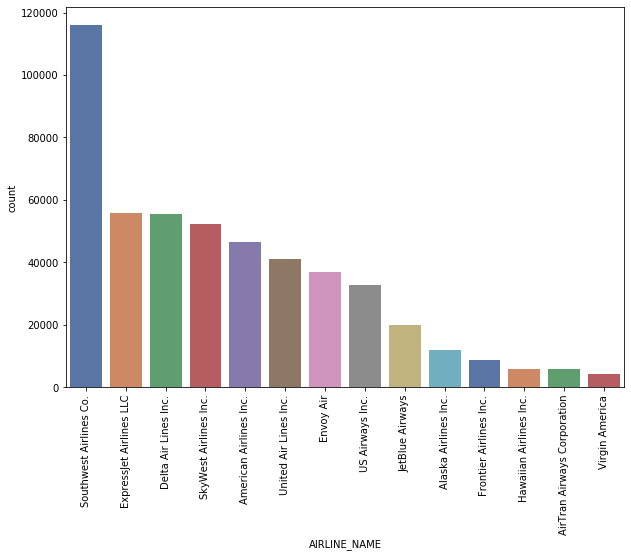

In [7]:
#AIRLINE DECISION
#
plt.figure(figsize=(10,7))
g=sns.countplot(x='AIRLINE_NAME', data=list_data[0], palette="deep", order = list_data[0]['AIRLINE_NAME'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(),rotation=90);

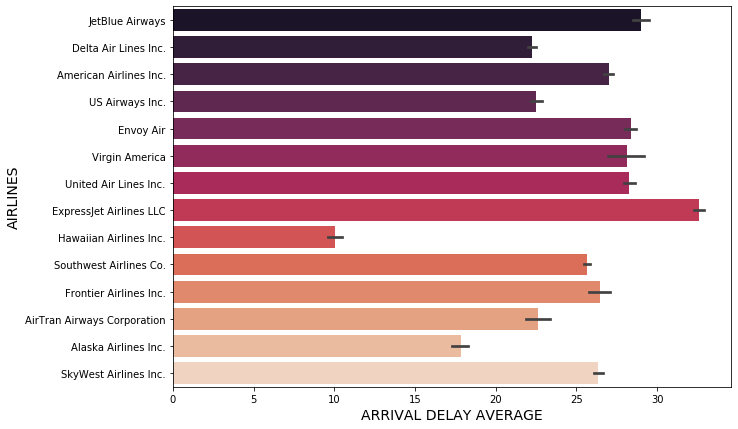

In [8]:
# AIRLINE DELAY AVERAGE
plt.figure(figsize=(10,7))
ax1=sns.barplot(y="AIRLINE_NAME", x="ARRIVAL_DELAY",data=list_data[0],palette='rocket')
plt.xlabel('ARRIVAL DELAY AVERAGE', fontsize=14)
plt.ylabel('AIRLINES', fontsize=14)
plt.show()

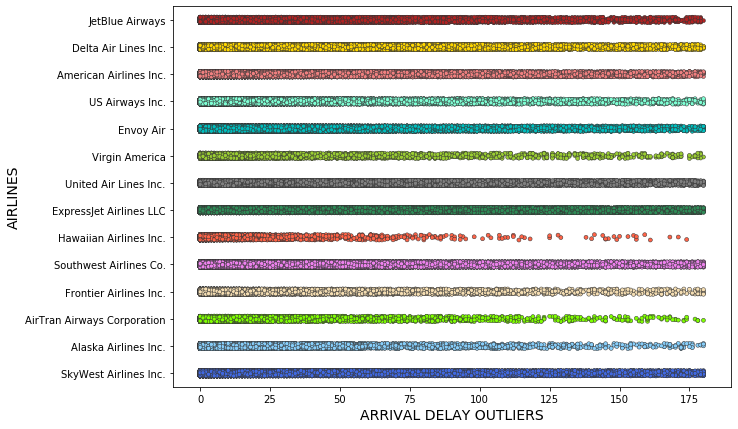

<Figure size 720x504 with 0 Axes>

In [9]:
# CHECKING OUTLIERS
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
plt.figure(figsize=(10,7))
ax2=sns.stripplot(y="AIRLINE_NAME", x="ARRIVAL_DELAY", size = 4, palette = colors,
                    data=list_data[0], linewidth = 0.5,  jitter=True)
plt.xlabel('ARRIVAL DELAY OUTLIERS', fontsize=14)
plt.ylabel('AIRLINES', fontsize=14)
plt.figure(figsize=(10,7))
plt.show()

In [97]:
# American Airlines (AA)
df_AA=list_data[0][list_data[0]['AIRLINE']=='AA']

In [98]:
variables_to_remove=['AIRLINE','AIRLINE_NAME','OR_LATITUDE', 'OR_LONGITUDE', 'DEST_LATITUDE', 
                 'DEST_LONGITUDE','DEPARTURE_DELAY']
df_AA=df_AA.drop(variables_to_remove, axis=1)

In [99]:
df_AA.head(100)

,DATE,ORIGIN,DESTIN,SCHED_DEPARTURE,SCHED_ARRIVAL,ARRIVAL_DELAY,DISTANCE,DATE_TIME
3,2014-02-07,AUS,JFK,10:15:00,14:50:00,18.0,1521.0,2014-02-07 10:15:00
7,2014-02-13,AUS,JFK,10:15:00,14:50:00,16.0,1521.0,2014-02-13 10:15:00
11,2014-06-05,AUS,JFK,10:05:00,14:55:00,23.0,1521.0,2014-06-05 10:05:00
14,2014-11-09,AUS,JFK,10:00:00,14:35:00,22.0,1521.0,2014-11-09 10:00:00
25,2014-06-25,AUS,JFK,10:05:00,14:55:00,26.0,1521.0,2014-06-25 10:05:00
...,...,...,...,...,...,...,...,...
973,2014-01-26,ORD,JFK,13:00:00,16:20:00,14.0,740.0,2014-01-26 13:00:00
974,2014-11-17,ORD,JFK,12:55:00,16:05:00,32.0,740.0,2014-11-17 12:55:00
977,2014-11-18,ORD,JFK,19:55:00,23:05:00,24.0,740.0,2014-11-18 19:55:00
979,2014-11-23,ORD,JFK,19:55:00,23:05:00,46.0,740.0,2014-11-23 19:55:00


In [100]:
df_AA['DATE_TIME']=pd.to_datetime(df_AA['DATE_TIME'], format= '%Y-%m-%d %H:%M:%S')
df_AA['MONTH']=[ x.month for x in df_AA['DATE_TIME']]
df_AA['HOUR']=[ x.hour for x in df_AA['DATE_TIME']]
df_AA['DAYOFWEEK']=[ x.dayofweek for x in df_AA['DATE_TIME']]
#to date_time
df_AA['SCHEDULED_DEPARTURE']=pd.to_datetime(df_AA['SCHED_DEPARTURE'], format= '%H:%M:%S') #to date_time
conversion = lambda x:x.hour*3600+x.minute*60+x.second 
df_AA['SCHEDULED_DEPARTURE']= np.array([conversion(s) for s in df_AA['SCHED_DEPARTURE']]) #conversion to seconds


df_AA_DATE=df_AA.groupby(df_AA['DATE_TIME']).mean()

df_AA_DATE.head(100)

,ARRIVAL_DELAY,DISTANCE,MONTH,HOUR,DAYOFWEEK,SCHEDULED_DEPARTURE
DATE_TIME,,,,,,
2014-01-01 00:20:00,2.000000,1464.000000,1,0,2,1200
2014-01-01 05:30:00,0.000000,1258.000000,1,5,2,19800
2014-01-01 05:45:00,14.666667,1121.666667,1,5,2,20700
2014-01-01 05:50:00,0.000000,551.000000,1,5,2,21000
2014-01-01 06:00:00,24.000000,853.000000,1,6,2,21600
...,...,...,...,...,...,...
2014-01-01 20:20:00,12.000000,1464.000000,1,20,2,73200
2014-01-01 20:25:00,5.000000,1121.000000,1,20,2,73500
2014-01-01 20:30:00,3.000000,985.000000,1,20,2,73800


In [101]:
df_AA.head(100)

,DATE,ORIGIN,DESTIN,SCHED_DEPARTURE,SCHED_ARRIVAL,ARRIVAL_DELAY,DISTANCE,DATE_TIME,MONTH,HOUR,DAYOFWEEK,SCHEDULED_DEPARTURE
3,2014-02-07,AUS,JFK,10:15:00,14:50:00,18.0,1521.0,2014-02-07 10:15:00,2,10,4,36900
7,2014-02-13,AUS,JFK,10:15:00,14:50:00,16.0,1521.0,2014-02-13 10:15:00,2,10,3,36900
11,2014-06-05,AUS,JFK,10:05:00,14:55:00,23.0,1521.0,2014-06-05 10:05:00,6,10,3,36300
14,2014-11-09,AUS,JFK,10:00:00,14:35:00,22.0,1521.0,2014-11-09 10:00:00,11,10,6,36000
25,2014-06-25,AUS,JFK,10:05:00,14:55:00,26.0,1521.0,2014-06-25 10:05:00,6,10,2,36300
...,...,...,...,...,...,...,...,...,...,...,...,...
973,2014-01-26,ORD,JFK,13:00:00,16:20:00,14.0,740.0,2014-01-26 13:00:00,1,13,6,46800
974,2014-11-17,ORD,JFK,12:55:00,16:05:00,32.0,740.0,2014-11-17 12:55:00,11,12,0,46500
977,2014-11-18,ORD,JFK,19:55:00,23:05:00,24.0,740.0,2014-11-18 19:55:00,11,19,1,71700
979,2014-11-23,ORD,JFK,19:55:00,23:05:00,46.0,740.0,2014-11-23 19:55:00,11,19,6,71700


In [102]:
le=LabelEncoder()
df_AA['ORIGIN_LABEL']=le.fit_transform(df_AA['ORIGIN'])
df_AA['DESTIN_LABEL']=le.fit_transform(df_AA['DESTIN'])

In [15]:
df_AA.head(100)

,DATE,ORIGIN,DESTIN,SCHED_DEPARTURE,SCHED_ARRIVAL,ARRIVAL_DELAY,DISTANCE,DATE_TIME,MONTH,HOUR,SCHEDULED_DEPARTURE,ORIGIN_LABEL,DESTIN_LABEL
3,2014-02-07,AUS,JFK,10:15:00,14:50:00,18.0,1521.0,2014-02-07 10:15:00,2,10,36900,3,36
7,2014-02-13,AUS,JFK,10:15:00,14:50:00,16.0,1521.0,2014-02-13 10:15:00,2,10,36900,3,36
11,2014-06-05,AUS,JFK,10:05:00,14:55:00,23.0,1521.0,2014-06-05 10:05:00,6,10,36300,3,36
14,2014-11-09,AUS,JFK,10:00:00,14:35:00,22.0,1521.0,2014-11-09 10:00:00,11,10,36000,3,36
25,2014-06-25,AUS,JFK,10:05:00,14:55:00,26.0,1521.0,2014-06-25 10:05:00,6,10,36300,3,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,2014-01-26,ORD,JFK,13:00:00,16:20:00,14.0,740.0,2014-01-26 13:00:00,1,13,46800,57,36
974,2014-11-17,ORD,JFK,12:55:00,16:05:00,32.0,740.0,2014-11-17 12:55:00,11,12,46500,57,36
977,2014-11-18,ORD,JFK,19:55:00,23:05:00,24.0,740.0,2014-11-18 19:55:00,11,19,71700,57,36
979,2014-11-23,ORD,JFK,19:55:00,23:05:00,46.0,740.0,2014-11-23 19:55:00,11,19,71700,57,36


In [44]:
le.fit(df_AA['ORIGIN'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'ABQ': 0, 'ANC': 1, 'ATL': 2, 'AUS': 3, 'BDL': 4, 'BHM': 5, 'BNA': 6, 'BOS': 7, 'BWI': 8, 'CLE': 9, 'CLT': 10, 'CMH': 11, 'COS': 12, 'CRP': 13, 'DAY': 14, 'DCA': 15, 'DEN': 16, 'DFW': 17, 'DSM': 18, 'DTW': 19, 'EGE': 20, 'ELP': 21, 'EWR': 22, 'FAT': 23, 'FLL': 24, 'GUC': 25, 'HDN': 26, 'HNL': 27, 'HOU': 28, 'HSV': 29, 'IAD': 30, 'IAH': 31, 'ICT': 32, 'IND': 33, 'JAC': 34, 'JAX': 35, 'JFK': 36, 'KOA': 37, 'LAS': 38, 'LAX': 39, 'LBB': 40, 'LGA': 41, 'LIH': 42, 'LIT': 43, 'MCI': 44, 'MCO': 45, 'MEM': 46, 'MFE': 47, 'MIA': 48, 'MKE': 49, 'MSP': 50, 'MSY': 51, 'MTJ': 52, 'OGG': 53, 'OKC': 54, 'OMA': 55, 'ONT': 56, 'ORD': 57, 'ORF': 58, 'PBI': 59, 'PDX': 60, 'PHL': 61, 'PHX': 62, 'PIT': 63, 'PNS': 64, 'PSP': 65, 'RDU': 66, 'RIC': 67, 'RNO': 68, 'RSW': 69, 'SAN': 70, 'SAT': 71, 'SDF': 72, 'SEA': 73, 'SFO': 74, 'SJC': 75, 'SJU': 76, 'SLC': 77, 'SMF': 78, 'SNA': 79, 'STL': 80, 'STT': 81, 'STX': 82, 'TPA': 83, 'TUL': 84, 'TUS': 85, 'XNA': 86}


In [45]:
le.fit(df_AA['DESTIN'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'ABQ': 0, 'ANC': 1, 'ATL': 2, 'AUS': 3, 'BDL': 4, 'BHM': 5, 'BNA': 6, 'BOS': 7, 'BWI': 8, 'CLE': 9, 'CLT': 10, 'CMH': 11, 'COS': 12, 'CRP': 13, 'DAY': 14, 'DCA': 15, 'DEN': 16, 'DFW': 17, 'DSM': 18, 'DTW': 19, 'EGE': 20, 'ELP': 21, 'EWR': 22, 'FAT': 23, 'FLL': 24, 'GUC': 25, 'HDN': 26, 'HNL': 27, 'HOU': 28, 'HSV': 29, 'IAD': 30, 'IAH': 31, 'ICT': 32, 'IND': 33, 'JAC': 34, 'JAX': 35, 'JFK': 36, 'KOA': 37, 'LAS': 38, 'LAX': 39, 'LBB': 40, 'LGA': 41, 'LIH': 42, 'LIT': 43, 'MCI': 44, 'MCO': 45, 'MEM': 46, 'MFE': 47, 'MIA': 48, 'MKE': 49, 'MSP': 50, 'MSY': 51, 'MTJ': 52, 'OGG': 53, 'OKC': 54, 'OMA': 55, 'ONT': 56, 'ORD': 57, 'ORF': 58, 'PBI': 59, 'PDX': 60, 'PHL': 61, 'PHX': 62, 'PIT': 63, 'PNS': 64, 'PSP': 65, 'RDU': 66, 'RIC': 67, 'RNO': 68, 'RSW': 69, 'SAN': 70, 'SAT': 71, 'SDF': 72, 'SEA': 73, 'SFO': 74, 'SJC': 75, 'SJU': 76, 'SLC': 77, 'SMF': 78, 'SNA': 79, 'STL': 80, 'STT': 81, 'STX': 82, 'TPA': 83, 'TUL': 84, 'TUS': 85, 'XNA': 86}


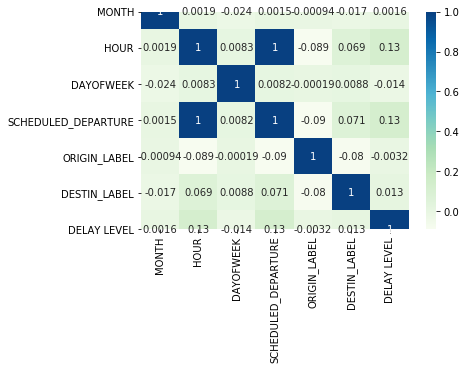

In [121]:
#CORRELATION MATRIX (Pearson Correlation)
corrmat=df_AA.corr()
ax = sns.heatmap(corrmat, annot=True, cmap="GnBu")

In [103]:
df_AA['DELAY LEVEL']=df_AA.apply(classes, axis=1)

In [104]:
df_AA.drop(['DATE','ORIGIN','DESTIN','SCHED_DEPARTURE',
                        'SCHED_ARRIVAL','DATE_TIME','ARRIVAL_DELAY','DISTANCE'], inplace=True, axis=1)

In [105]:
df_AA['DELAY LEVEL'].value_counts()

0    23507
1    19957
2     3131
Name: DELAY LEVEL, dtype: int64

In [106]:
df_AA.head()

,MONTH,HOUR,DAYOFWEEK,SCHEDULED_DEPARTURE,ORIGIN_LABEL,DESTIN_LABEL,DELAY LEVEL
3,2,10,4,36900,3,36,1
7,2,10,3,36900,3,36,1
11,6,10,3,36300,3,36,1
14,11,10,6,36000,3,36,1
25,6,10,2,36300,3,36,1


In [107]:
#CLASIFICACIÓN
#Random forest
#sample aleatorio de un año
#Separamos la columna con la información del delay_level
X = np.array(df_AA.drop(['DELAY LEVEL'],1))
y = np.array(df_AA['DELAY LEVEL'])

In [108]:
#Separamos los datos en train y test, con una proporción de un 70% y 30%, respectivamente.
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3)

In [109]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
print(class_weights)

[0.65850999 0.78036176 5.00091996]


In [61]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [119]:
class_weight = dict({0:0.6622, 1:0.7743, 2:5.001})
rnd_forest = RandomForestClassifier(n_estimators = 500, criterion = 'gini', random_state = 42, class_weight=class_weight)
rnd_forest.fit(X_train, y_train)
y_pred_rnd_forest = rnd_forest.predict(X_test)

In [120]:
#Precisión en la clasificación de los valores de entrenamiento
acc_rnd_forest_train = round(rnd_forest.score(X_train, y_train) * 100, 2)
print ('1. Train accuracy {}\n'.format(acc_rnd_forest_train))

# Precisión en la clasificación de los valores de test
acc_rnd_forest = accuracy_score(y_test, y_pred_rnd_forest)
print ('2. Test accuracy {}\n'.format(acc_rnd_forest*100))

# Report
print('3. Classfication Report {}\n'.format(classification_report(y_test,y_pred_rnd_forest)))

# Matriz de confusión
print('4. Confusion Matrix')
print(confusion_matrix(y_test, y_pred_rnd_forest))

1. Train accuracy 95.38

2. Test accuracy 49.10937835324415

3. Classfication Report               precision    recall  f1-score   support

           0       0.53      0.60      0.56      6997
           1       0.46      0.44      0.45      6025
           2       0.07      0.03      0.04       957

    accuracy                           0.49     13979
   macro avg       0.35      0.35      0.35     13979
weighted avg       0.47      0.49      0.48     13979


4. Confusion Matrix
[[4191 2652  154]
 [3209 2650  166]
 [ 474  459   24]]


C:\Users\alex_\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.25580447 0.05074921 0.25915598 0.20953682 0.22475351]


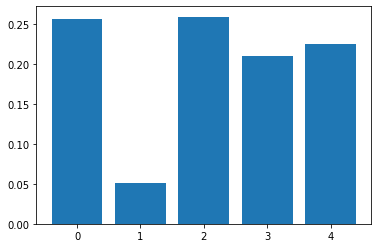

In [94]:
#Para obtener la importancia de cada variable inicializamos el  ExtraTreesClassifier
model = ExtraTreesClassifier()

#Ajustamos el modelo
model.fit(X_train,y_train)

#Pedimos que nos muestre la importancia de cada variable
print(model.feature_importances_)

#Para dibujar todos las variables con su importancia
from matplotlib import pyplot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()